In [1]:
# Importing libraries
import os
import glob
import re
import nltk
import tensorflow as tf
import numpy as np
from random import randint
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import Counter
from collections import defaultdict
print(tf.__version__)

In [2]:
# download the IMDB large movie review corpus from the class webpage to a file location on your computer

PATH_TO_DATA = '../large_movie_review_dataset'  # set this variable to point to the location of the IMDB corpus on your computer
POS_LABEL = 'pos'
NEG_LABEL = 'neg'
TRAIN_DIR = os.path.join(PATH_TO_DATA, "train")
TEST_DIR = os.path.join(PATH_TO_DATA, "test")

for label in [POS_LABEL, NEG_LABEL]:
    if len(os.listdir(TRAIN_DIR + "/" + label)) == 12500:
        print "Great! You have 12500 {} reviews in {}".format(label, TRAIN_DIR + "/" + label)
    else:
        print "Oh no! Something is wrong. Check your code which loads the reviews"

Great! You have 12500 pos reviews in ../large_movie_review_dataset/train/pos
Great! You have 12500 neg reviews in ../large_movie_review_dataset/train/neg


In [3]:
def tokenize_doc_and_more(doc):
    bow = defaultdict(float)
    
    # Converting into lower case text
    doc_lower = doc.lower() 
    
    # removing pucntuations ("..", ".", ",")
    doc_wo_punc = re.sub(r'(\.+$|\?+$|\,|\'|\.{2,}|<br *(/>)?)|-',"",doc_lower)
    #doc_wo_punc = re.sub(r"[^A-Za-z0-9 ]+","", doc_lower)
    # removing two spaces 
    text_with_one_space = re.sub(r'[ ]{2,}'," ", doc_wo_punc).split()
    
    # removing stop words like "and", "the"
    stop_words = set(stopwords.words('english'))
    filtered_sentence = [w for w in text_with_one_space if not w in stop_words]
    return filtered_sentence

In [4]:
print tokenize_doc_and_more("I was looking forward to The Guardian, but when I walked into the theater I wasn't really in the mood for it at that particular time. It's kind of like the Olive Garden - I like it, but I have to be in the right mindset to thoroughly enjoy it.<br /><br />I'm not exactly sure what was dampening my spirit")

['looking', 'forward', 'guardian', 'walked', 'theater', 'wasnt', 'really', 'mood', 'particular', 'time.', 'kind', 'like', 'olive', 'garden', 'like', 'right', 'mindset', 'thoroughly', 'enjoy', 'it.im', 'exactly', 'sure', 'dampening', 'spirit']


In [8]:
# Reading dataset and making list of list for positive and negative training examples.
positiveSentence = []
negativeSentence = []
numberofWords = []
for label in [POS_LABEL, NEG_LABEL]:
    for directory in [TRAIN_DIR, TEST_DIR]:
        for fn in glob.glob(directory + "/" + label + "/*txt"):
            ## Implement me!
            temp = tokenize_doc_and_more(open(fn).read())
            numberofWords.append(len(temp))
            if label == POS_LABEL:
                positiveSentence.append(temp)
            else:
                negativeSentence.append(temp)
                

In [9]:
#Check the loaded data in the positive and negative sentence
print "The number of positive examples " + str(len(positiveSentence))
print "The number of negative examples " + str(len(negativeSentence))

The number of positive examples 25000
The number of negative examples 25000


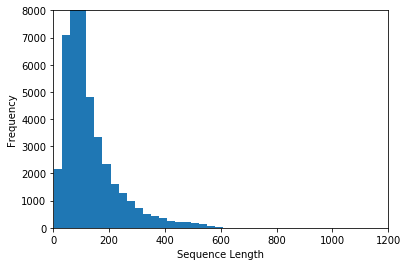

In [10]:
# Printing the number of words in all the sentences
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(numberofWords, 50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axis([0, 1200, 0, 8000])
plt.show()

# Maximum length of words is about 600, but most sentence are covered in 250 words.


In [7]:
maxSeqLength = 250
batchSize = 24
numDimensions = 50
numFiles= 50000
numClasses = 2
lstmUnits = 64
iterations = 100000
keep_prob = 0.75

In [3]:
wordVector = np.load('wordVectors.npy')

In [4]:
# Number of words in the the word vector 
print len(list(wordVector))

400000


# The Ids Matrix Conversion

In [ ]:
# Traning and Testing Batch 


In [ ]:
# Initializing input label and respective embedding matrix
label = tf.placeholder(tf.float32, [batchSize, numClasses])
input_data = tf.placeholder(tf.int32, [batchSize, maxSeqLength])

In [ ]:
# Creating the data variable and performing lookup function
data = tf.Variable(tf.zeros([batchSize, maxSeqLength, numDimensions], tf.float32))
data = tf.nn.embedding_lookup(wordVector, input_data)

# Initializing the model
Now that we have the data in the format that we want, let’s look at how we can feed this input into an LSTM network. We’re going to call the tf.nn.rnn_cell.BasicLSTMCell function. This function takes in an integer for the number of LSTM units that we want. This is one of the hyperparameters that will take some tuning to figure out the optimal value. We’ll then wrap that LSTM cell in a dropout layer to help prevent the network from overfitting.


Finally, we’ll feed both the LSTM cell and the 3-D tensor full of input data into a function called tf.nn.dynamic_rnn. This function is in charge of unrolling the whole network and creating a pathway for the data to flow through the RNN graph.

In [ ]:
lstmCell = tf.contrib.rnn.BasicLSTMCell(lstmUnits)
lstmCell = tf.contrib.rnn.DropoutWrapper(cell = lstmcell, input_keep_prob= keep_probss)
value, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32)

In [ ]:
weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]))
bias = tf.Variable(tf.constant(0.1, shape=[numClasses]))
value = tf.transpose(value, [1, 0, 2])
last = tf.gather(value, int(value.get_shape()[0]) - 1)
prediction = (tf.matmul(last, weight) + bias)

In [ ]:
correctPred = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))

In [ ]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=labels))
optimizer = tf.train.AdamOptimizer().minimize(loss)

In [ ]:
import datetime

tf.summary.scalar('Loss', loss)
tf.summary.scalar('Accuracy', accuracy)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)